# GP Practices with large volume of GP2GP transfers and failures

Hypothesis:
- We believe that GPs who are impacted with large volumes of GP2GP transfers and failures will be feeling pain, and will be more likely to participate in user research

Questions:
- Which practices have large volumes of GP2GP transfers?
  - Which practices have large volumes of GP2GP transfers as a sending practice?
  - Which practices have large volumes of GP2GP transfers as a receiving practice? 
- Which practices have large volumes of GP2GP transfer failures?
- Which practices have large volumes of GP2GP transfer success?

Other considerations:
- GP2GP utilisation may change month-over-month; thus look at patterns over time, not just for a single time period

## Requesting practices

We'll export data from NMS using the following Splunk query:

```splunk
index="gp2gp-mi" sourcetype="gppractice-RR"
| eval key=RegistrationTime + "-" + RegistrationSmartcardUID
| eval Outcome=coalesce(ExtractAckStatus, "No") + "-" + coalesce(ExtractAckCode, "EAM")
| eval Month=substr(RegistrationTime, 6, 2)
| stats values(RequestorODS) as RequestorODS,
        max(eval(isnotnull(ConversationID))) as GP2GPRequest,
        dc(eval(Outcome="1-00" or Outcome="1-0")) as Integrated,
        dc(eval(Outcome="5-15")) as Suppressed,
        BY key, Month
| stats dc(key) as RegistrationCount,
        sum(GP2GPRequest) as RequestCount,
        sum(Integrated) as IntegratedCount,
        sum(Suppressed) as SuppressedCount
        BY RequestorODS, Month
| eval SuccessRate=(IntegratedCount + SuppressedCount)/RequestCount
```


Exported the above as `data/PRMT-365-Requestor-transfer.csv` for further analysis (below).

In [1]:
import paths
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import data

In [3]:
%matplotlib inline

In [4]:
requestor_view = pd.read_csv(data.PRMT_365_Requestor_transfers.path)
requestor_view["SuccessCount"] = requestor_view["IntegratedCount"] + requestor_view["SuppressedCount"]
requestor_view["Month"] = requestor_view["Month"].map({5:"May", 6:"June", 7:"July", 8:"August"})
requestor_view = requestor_view.set_index(["RequestorODS", "Month"])

months = ["May","June","July","August"]
ODSs = list(set(requestor_view.index.get_level_values("RequestorODS")))
CompleteIndex = pd.MultiIndex.from_product([ODSs, months], names=["RequestorODS", "Month"])
requestor_view = requestor_view.reindex(CompleteIndex)

In [5]:
ods_lookup = pd.read_csv(
    data.GP_ODS_Data.path,
    names=data.GP_ODS_Data.columns,
    index_col="ODSCode",
    usecols=["ODSCode","Name","NationalGrouping","HighLevelHealthGeography","Postcode",
             "PrescribingSetting","ContactTelephoneNumber"]
)

In [6]:
requestor_view_aggregated_over_time = requestor_view.groupby(by="RequestorODS").sum()[
    ["RegistrationCount", "RequestCount", "IntegratedCount", "SuppressedCount", "SuccessCount"]
]
requestor_view_aggregated_over_time["SuccessRate"] = (requestor_view_aggregated_over_time["SuccessCount"]
                                                      /requestor_view_aggregated_over_time["RequestCount"])
requestor_view_aggregated_over_time = pd.merge(
    requestor_view_aggregated_over_time,
    ods_lookup,
    how="inner",
    left_index=True,
    right_index=True
)

A histogram of `RequestCount` aggregated over all 4 months (below) shows that:
- The vast majority of practices made fewer than 200 requests over the 4 month period
- Note that there were a few practices that made substantially more GP2GP requests (>1000; in one case, >7000) over the 4 months - these are not visible on the graph.

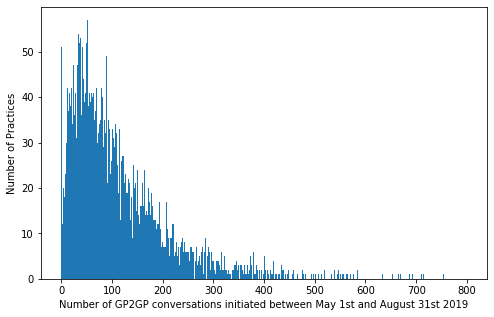

In [7]:
plt.figure(figsize=(8,5))
plt.hist(requestor_view_aggregated_over_time["RequestCount"], bins=np.linspace(0,800,800));
plt.xlabel("Number of GP2GP conversations initiated between May 1st and August 31st 2019");
plt.ylabel("Number of Practices");

A histogram of `SuccessRate` aggregated over all 4 months (below) shows that:

- A large majority of practices have a success rate of between 90% and 100%, with very few practices in the range 0% < SuccessRate < 90%.
- There remains a sizeable number of practices with quite low success rate

/Users/dmortime/dev/NHS/prm-gp2gp-data-sandbox/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dmortime/dev/NHS/prm-gp2gp-data-sandbox/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


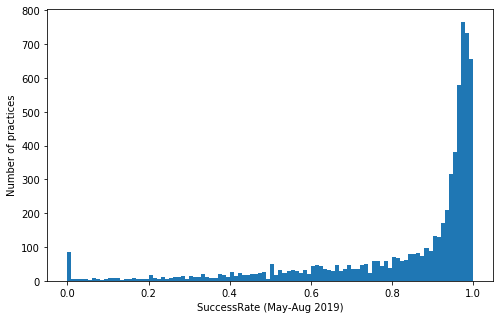

In [8]:
plt.figure(figsize=(8,5))
plt.hist(list(requestor_view_aggregated_over_time.sort_values(by="SuccessRate", ascending=True)["SuccessRate"]),
         bins=100);
plt.xlabel("SuccessRate (May-Aug 2019)");
plt.ylabel("Number of practices");

### Practices making a high volume of GP2GP requests

The practices that made more than 800 requests in the period from May to August 2019 were:

In [9]:
high_volume_practices = requestor_view_aggregated_over_time[requestor_view_aggregated_over_time["RequestCount"] > 800].sort_values(by="RequestCount", ascending=False)
high_volume_practices

,RegistrationCount,RequestCount,IntegratedCount,SuppressedCount,SuccessCount,SuccessRate,Name,NationalGrouping,HighLevelHealthGeography,Postcode,ContactTelephoneNumber,PrescribingSetting
E85124,14936.0,7587.0,6829.0,0.0,6829.0,0.900092,GP AT HAND,Y56,Q71,SW6 7SX,0330 8082217,4
G85034,5486.0,3911.0,3456.0,387.0,3843.0,0.982613,NEXUS HEALTH GROUP,Y56,Q71,SE1 6JP,020 79280253,4
L81078,3397.0,3089.0,3000.0,62.0,3062.0,0.991259,GLOUCESTER ROAD MEDICAL CENTRE,Y58,Q86,BS7 8SA,0117 9497774,4
F84003,2553.0,2208.0,2048.0,122.0,2170.0,0.982790,LOWER CLAPTON GROUP PRACTICE,Y56,Q71,E5 0PQ,020 89867111,4
P91629,2388.0,2179.0,1949.0,166.0,2115.0,0.970629,NORTH TRAFFORD GROUP PRACTICE,Y62,Q83,M32 0PA,0161 8655556,4
P91020,2216.0,2038.0,1871.0,142.0,2013.0,0.987733,BROOKS BAR MEDICAL CENTRE,Y62,Q83,M16 9NW,0161 2267777,4
F84724,2303.0,1882.0,1801.0,69.0,1870.0,0.993624,WOODGRANGE MEDICAL PRACTICE,Y56,Q71,E7 0QH,020 82213100,4
H81122,1879.0,1769.0,1697.0,62.0,1759.0,0.994347,HYTHE MEDICAL CENTRE SURGERY,Y59,Q88,TW18 3HN,01784 454965,4
K81041,1711.0,1600.0,1559.0,32.0,1591.0,0.994375,EMMER GREEN SURGERY,Y59,Q87,RG4 8RA,0118 9486900,4
Y01206,1596.0,1421.0,1345.0,26.0,1371.0,0.964814,BOTTING (GLEBE),Y56,Q71,SW13 0DR,020 87481065,4


## Sending practices

We'll still use the `gppractice-RR` source for now, as we are interested in the ultimate outcome of the interaction, and this is only reported in this view. We can still identify the sending practice ODS.

There are a small number of conversations where the Requestor initiates a conversation with itself (i.e. it identifies itself as the Sender). I believe this occurs when a registration incorrectly triggers multiple GP2GP conversations, with one occurring after PDS has been updated for the patient to indicate that the Requestor is their primary care provider. These don't seem to have any impact in practice (they lead to a well-defined error code), so we'll just filter them out with `RequestorODS != SenderODS`.

```sql
index="gp2gp-mi" sourcetype="gppractice-RR"
| where isnotnull(ConversationID) and RequestorODS != SenderODS
| eval key=RegistrationTime + "-" + RegistrationSmartcardUID
| eval Outcome=coalesce(ExtractAckStatus, "No") + "-" + coalesce(ExtractAckCode, "EAM")
| eval Month=substr(RegistrationTime, 6, 2)
| stats values(RequestorODS) as RequestorODS,
        values(SenderODS) as SenderODS,
        dc(eval(Outcome="1-00" or Outcome="1-0")) as Integrated,
        dc(eval(Outcome="5-15")) as Suppressed,
        BY key, Month
| stats dc(key) as RequestCount,
        sum(Integrated) as IntegratedCount,
        sum(Suppressed) as SuppressedCount
        BY SenderODS, Month
| eval SuccessRate=(IntegratedCount + SuppressedCount)/RequestCount
```

In [10]:
sender_view = pd.read_csv(data.PRMT_365_Sender_transfers.path)
sender_view["Month"] = sender_view["Month"].map({5:"May", 6:"June", 7:"July", 8:"August"})
sender_view["SuccessCount"] = sender_view["IntegratedCount"] + sender_view["SuppressedCount"]
sender_view = sender_view.set_index(["SenderODS", "Month"])

months = ["May","June","July","August"]
ODSs = list(set(sender_view.index.get_level_values("SenderODS")))
CompleteIndex = pd.MultiIndex.from_product([ODSs, months], names=["SenderODS", "Month"])
sender_view = sender_view.reindex(CompleteIndex)

In [11]:
sender_view_aggregated_over_time = sender_view.groupby(by="SenderODS").sum()[
    ["RequestCount", "IntegratedCount", "SuppressedCount", "SuccessCount"]
]
sender_view_aggregated_over_time["SuccessRate"] = (sender_view_aggregated_over_time["SuccessCount"]
                                                      /sender_view_aggregated_over_time["RequestCount"])
sender_view_aggregated_over_time = pd.merge(
    sender_view_aggregated_over_time, ods_lookup,
    how="inner",
    left_index=True,
    right_index=True
)

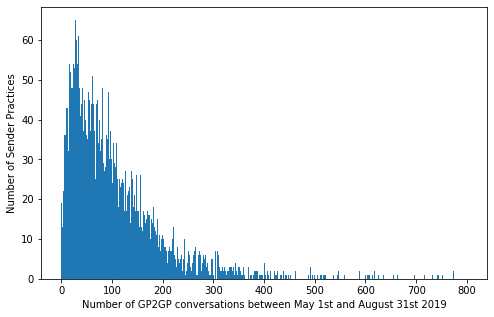

In [12]:
plt.figure(figsize=(8,5))
plt.hist(sender_view_aggregated_over_time["RequestCount"], bins=np.linspace(0,800,800));
plt.xlabel("Number of GP2GP conversations between May 1st and August 31st 2019");
plt.ylabel("Number of Sender Practices");

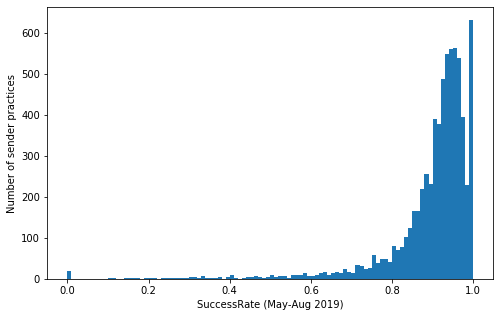

In [13]:
plt.figure(figsize=(8,5))
plt.hist(list(sender_view_aggregated_over_time.sort_values(by="SuccessRate", ascending=True)["SuccessRate"]),
         bins=100);
plt.xlabel("SuccessRate (May-Aug 2019)");
plt.ylabel("Number of sender practices");

### Practices involved as Senders in a large number of GP2GP conversations

The practices that responded to more than 800 requests in the period from May to August 2019 were:

In [14]:
high_volume_senders = sender_view_aggregated_over_time[sender_view_aggregated_over_time["RequestCount"] > 800].sort_values(by="RequestCount", ascending=False)
high_volume_senders.iloc[:10]

,RequestCount,IntegratedCount,SuppressedCount,SuccessCount,SuccessRate,Name,NationalGrouping,HighLevelHealthGeography,Postcode,ContactTelephoneNumber,PrescribingSetting
L81112,4762.0,4550.0,133.0,4683.0,0.983410,BISHOPSTON MEDICAL PRACTICE,Y58,Q86,BS7 9EG,0117 9440700,4
P91615,4410.0,4071.0,268.0,4339.0,0.983900,GORSE HILL MEDICAL CENTRE,Y62,Q83,M32 0RN,0161 8642496,4
F84631,3536.0,3435.0,60.0,3495.0,0.988405,LORD LISTER HEALTH CENTRE,Y56,Q71,E7 0EP,020 85207550,4
G85050,2931.0,2578.0,300.0,2878.0,0.981917,SIR JOHN KIRK CLOSE SURGERY,Y56,Q71,SE5 0BB,020 77032046,4
H81079,2885.0,2731.0,78.0,2809.0,0.973657,STAINES THAMESIDE MEDICAL,Y59,Q88,TW18 3JH,01784 454164,4
F84043,2640.0,2540.0,43.0,2583.0,0.978409,THE SORSBY HEALTH CENTRE,Y56,Q71,E5 0DH,020 89865613,4
B86110,2584.0,1528.0,691.0,2219.0,0.858746,LEEDS STUDENT MEDICAL PRACTICE,Y63,Q72,LS2 9AE,0113 2954488,4
K81647,2511.0,2462.0,39.0,2501.0,0.996018,PEPPARD ROAD SURGERY,Y59,Q87,RG4 8NR,0118 9462224,4
E85124,2328.0,1794.0,428.0,2222.0,0.954467,GP AT HAND,Y56,Q71,SW6 7SX,0330 8082217,4
L81028,2300.0,1982.0,69.0,2051.0,0.891739,NORTHVILLE FAMILY PRACTICE,Y58,Q86,BS7 0LS,0117 9692164,4


## Looking at individual practices

In [15]:
def view_trends_for_ods(ods):
    requestor_data = requestor_view.loc[ods]
    sender_data = sender_view.loc[ods]
    months = ["May", "June", "July", "August"]
    
    print(ods_lookup.loc[ods])
    
    figure = plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    plt.plot(months, requestor_data[["RequestCount", "IntegratedCount", "SuccessCount"]])
    plt.ylim(0)
    plt.title(f"GP2GP requests, integrations, and suppressions ({ods} - Requestor)")

    plt.subplot(2, 2, 2)
    plt.plot(months, requestor_data["SuccessRate"])
    plt.ylim((0, 1.1))
    plt.title(f"Success rate ({ods} - Requestor)")
    
    plt.subplot(2, 2, 3)
    plt.plot(months, sender_data[["RequestCount", "IntegratedCount", "SuccessCount"]])
    plt.ylim(0)
    plt.title(f"GP2GP requests, integrations, and suppressions ({ods} - Sender)")

    plt.subplot(2, 2, 4)
    plt.plot(months, sender_data["SuccessRate"])
    plt.ylim((0, 1.1))
    plt.title(f"Success rate ({ods} - Sender)")

### High volume requestors

For ODS=E85124 ("GP At Hand" -- the largest volume of GP2GP transfer requests), we have:

Name                          GP AT HAND
NationalGrouping                     Y56
HighLevelHealthGeography             Q71
Postcode                         SW6 7SX
ContactTelephoneNumber      0330 8082217
PrescribingSetting                     4
Name: E85124, dtype: object


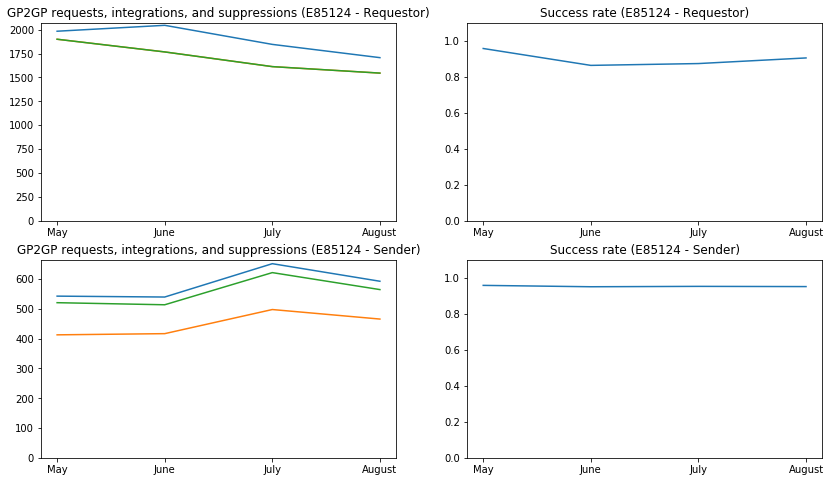

In [16]:
view_trends_for_ods("E85124")

### High volume senders

Name                        LEEDS STUDENT MEDICAL PRACTICE
NationalGrouping                                       Y63
HighLevelHealthGeography                               Q72
Postcode                                           LS2 9AE
ContactTelephoneNumber                        0113 2954488
PrescribingSetting                                       4
Name: B86110, dtype: object


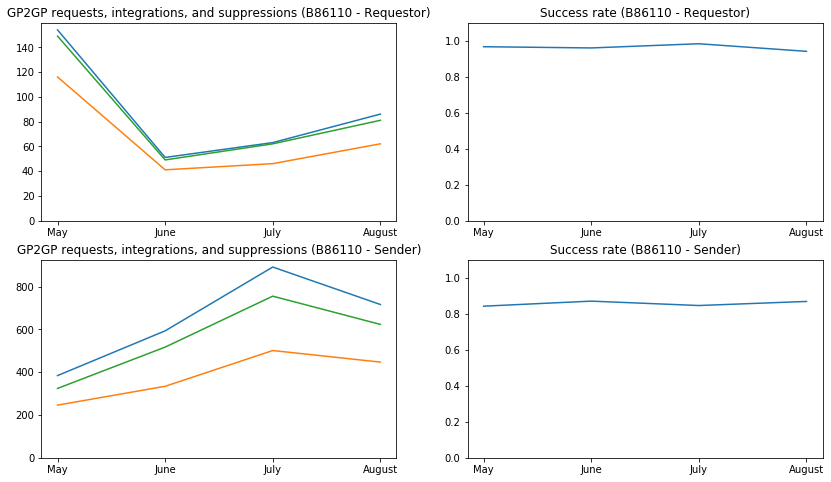

In [17]:
view_trends_for_ods("B86110")

# North-West London Practices

We have contact with people from the "NORTH WEST LONDON COLLABORATION OF CLINICAL COMMISSIONING GROUPS", who may be able to help with putting us in contact with GP practices for user research. This section focuses on finding practices within NW London that might be valuable to visit, based on volume of GP2GP transfers / success rate / etc.

## Requesting Practices

In [18]:
nw_london_requesting_practices_view = requestor_view_aggregated_over_time.loc[
    requestor_view_aggregated_over_time["Postcode"].str.contains('^NW', regex=True, na=False)
].sort_values(by="SuccessRate", ascending=True)

nw_london_requesting_practices_view[
    ["Name", "ContactTelephoneNumber", "Postcode", "RegistrationCount", "RequestCount", "IntegratedCount", "SuppressedCount", "SuccessCount", "SuccessRate"]
]

,Name,ContactTelephoneNumber,Postcode,RegistrationCount,RequestCount,IntegratedCount,SuppressedCount,SuccessCount,SuccessRate
E84011,ST ANDREWS MEDICAL CENTRE,020 84597755,NW10 9AR,10.0,1.0,0.0,0.0,0.0,0.000000
E83025,PENNINE DRIVE PRACTICE,020 84559977,NW2 1PA,190.0,97.0,0.0,0.0,0.0,0.000000
F83018,PRINCE OF WALES GROUP SURGERY,020 72670067,NW5 3LN,238.0,122.0,4.0,0.0,4.0,0.032787
Y02986,CRICKLEWOOD HEALTH CENTRE,0300 0334335,NW2 1DZ,416.0,157.0,43.0,2.0,45.0,0.286624
E84696,PEEL PRECINCT SURGERY,020 73722172,NW6 5DX,20.0,6.0,2.0,0.0,2.0,0.333333
...,...,...,...,...,...,...,...,...,...
F83677,THE MATTHEWMAN PRACTICE,020 72843888,NW5 3NT,51.0,24.0,22.0,2.0,24.0,1.000000
E83657,THE HILLVIEW SURGERY,020 82030546,NW4 1DG,54.0,17.0,16.0,1.0,17.0,1.000000
E84704,ST. GEORGES MEDICAL CENTRE,020 84504040,NW2 6JH,75.0,40.0,40.0,0.0,40.0,1.000000
E84624,PARK ROAD SURGERY,020 89655255,NW10 8TA,22.0,2.0,2.0,0.0,2.0,1.000000


The "Prince of Wales Group Surgery" (F83018) has a reasonable number of requests (122 from May-August), and a very low success rate (3%)

Name                        PRINCE OF WALES GROUP SURGERY
NationalGrouping                                      Y56
HighLevelHealthGeography                              Q71
Postcode                                          NW5 3LN
ContactTelephoneNumber                       020 72670067
PrescribingSetting                                      4
Name: F83018, dtype: object


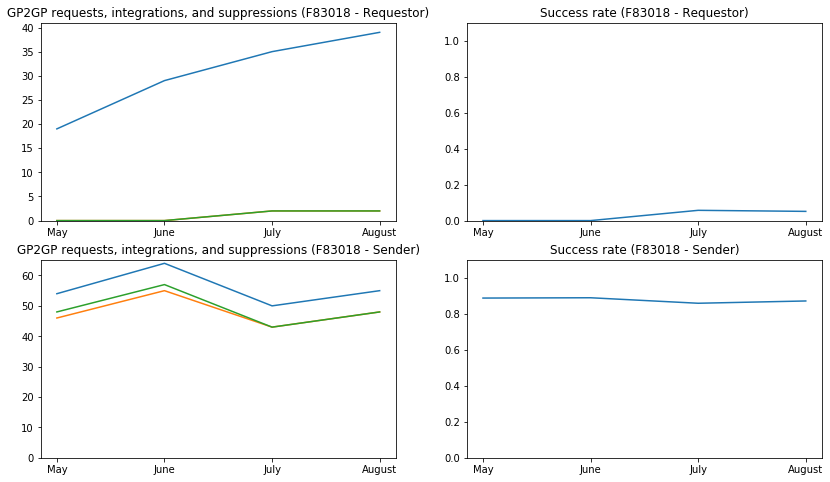

In [19]:
view_trends_for_ods("F83018")

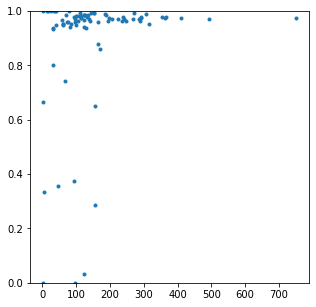

In [20]:
plt.figure(figsize=(5,5))
plt.plot(nw_london_requesting_practices_view.RequestCount, nw_london_requesting_practices_view.SuccessRate, marker=".", linestyle="");
plt.ylim((0, 1));

## Sending Practices

In [21]:
nw_london_sending_practices_view = sender_view_aggregated_over_time.loc[
    sender_view_aggregated_over_time["Postcode"].str.contains('^NW', regex=True, na=False)
].sort_values(by="SuccessRate", ascending=False)

nw_london_sending_practices_view[
    ["Name", "ContactTelephoneNumber", "Postcode", "RequestCount", "IntegratedCount", "SuppressedCount", "SuccessCount", "SuccessRate"]
]

,Name,ContactTelephoneNumber,Postcode,RequestCount,IntegratedCount,SuppressedCount,SuccessCount,SuccessRate
E84656,ROUNDWOOD PARK MEDICAL CENTRE,020 84387070,NW10 3RY,87.0,82.0,3.0,85.0,0.977011
E84011,ST ANDREWS MEDICAL CENTRE,020 84597755,NW10 9AR,40.0,39.0,0.0,39.0,0.975000
E87609,ST JOHNS WOOD MEDICAL PRACTICE,020 36579449,NW8 9NH,159.0,150.0,5.0,155.0,0.974843
E84028,THE STONEBRIDGE PRACTICE,020 31887310,NW10 8RY,73.0,66.0,5.0,71.0,0.972603
E84076,OXGATE GARDENS SURGERY,020 84327337,NW2 6EA,142.0,135.0,3.0,138.0,0.971831
...,...,...,...,...,...,...,...,...
E84674,CHICHELE ROAD SURGERY,020 84524666,NW2 3AN,170.0,135.0,7.0,142.0,0.835294
E83025,PENNINE DRIVE PRACTICE,020 84559977,NW2 1PA,127.0,105.0,0.0,105.0,0.826772
E84049,BRAMPTON HEALTH CENTRE,020 82046219,NW9 9BY,116.0,89.0,4.0,93.0,0.801724
Y02986,CRICKLEWOOD HEALTH CENTRE,0300 0334335,NW2 1DZ,236.0,181.0,7.0,188.0,0.796610


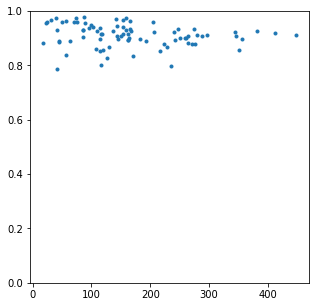

In [22]:
plt.figure(figsize=(5,5))
plt.plot(nw_london_sending_practices_view.RequestCount, nw_london_sending_practices_view.SuccessRate, marker=".", linestyle="");
plt.ylim((0, 1));